In [4]:
##MULTI TASK DEEP LEARNING NEURAL NETWORK

%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import torch
from bayes_opt import BayesianOptimization
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from math import sqrt
import itertools

#Load some of the data
exp_data = pd.read_csv('../exp.tab', sep='\t', index_col=0)
cnv_data = pd.read_csv('../cnv.tab', sep='\t', index_col=0)
ydat = pd.read_csv('../labels.tab', sep='\t', index_col=0)
train_activity_data = pd.read_csv('../train_activity.tab', sep='\t')
test_activity_data = pd.read_csv('../test_activity.tab', sep ='\t')

#labels
traininglabels = train_activity_data.columns[1:]
testinglabels = test_activity_data.columns[1:]

#concatenate two data frames
frames = [exp_data, cnv_data]

xdatw = pd.concat(frames)

In [5]:
#Deep Learning Net Class

class EssentialityNet:

    def __init__(self):
        self.inputnum = xdatw.shape[0]
        self.trainscores = []
        self.testscoreslist = []
        self.learning_rate = 0.00009
        self.H = 100
        self.n_iter = 300 #training iterations
        self.minimum = 100000
        self.stopcounter = 3
        self.layernum = 1
        self.layers = []
                
        #model
        self.model = torch.nn.Sequential(
        torch.nn.Linear(self.inputnum, self.H),
        torch.nn.ReLU(),
        torch.nn.Linear(self.H, 1138),
        )
        
        #set loss function and optimizer
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    #plot scores
    def plot(self, trainscores, testscores):
        x = np.arange(self.n_iter)
        plt.plot(x, self.trainscores, label='Train')
        plt.title('Training vs Test Accuracy')
        plt.xlabel('NN Training Iterations')
        plt.ylabel('Accuracy')
    
        plt.plot(np.asarray(x), np.asarray(testscores), label='Test') #plot
        plt.legend()
        
    #sets the proper method
    def setModel(self, Layernum, Neuronnum):  
        
        self.layernum = int(round(Layernum))
        self.H = int(round(Neuronnum))
        
        #initial input layer
        self.layers.append(torch.nn.Linear(self.inputnum, self.H))
        
        for n in range(self.layernum):
            if n != 0:
                self.layers.append(torch.nn.Linear(self.H, self.H))
            self.layers.append(torch.nn.ReLU())
            
        self.layers.append(torch.nn.Linear(self.H, 1138))
        
        #set the method to whatever layers were chosen
        self.model = torch.nn.Sequential(*self.layers)
    
    def setRegularization(self, L2Reg):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay= L2Reg)

    def fit(self, xtrain, ytrain, xtest, ytest):
      
        #convert to variables
        xtrain_var = Variable(torch.FloatTensor(xtrain))
        xtest_var = Variable(torch.FloatTensor(xtest))
        ytrain_var = Variable(torch.FloatTensor(ytrain.values))
        ytest_var = Variable(torch.FloatTensor(ytest.values))
        
        for t in range(self.n_iter):
        
            #calculate loss
            ypred = self.model(xtrain)

            diff = self.loss(ypred, ytrain_var)
            self.trainscores.append(diff.data[0])
            
            #test performance
            ypredtest = self.model(xtest_var)
            difftest = self.loss(ypredtest, ytest_var)
            
            #find the best point
            if t > 10 and self.minimum < difftest.data[0]:
                self.stopcounter -= 1

                if self.stopcounter == 0:
                    self.n_iter = t
                    self.trainscores.pop()
                    break
            elif t > 10 and self.stopcounter < 3:
                self.stopcounter += 1
            
            self.minimum = difftest.data[0]
            
            self.testscoreslist.append(difftest.data[0])
            
            #zero gradients
            self.optimizer.zero_grad()
            #backpropagate
            diff.backward() 
            #update weights
            self.optimizer.step() 

    # predict with the test data
    def predict(self, X):
        
        X_var = Variable(torch.FloatTensor(Χ))
        return self.model(X) 
    

In [4]:
#other functions for running the nn

def figureoutnetwork(layernum, neuronnum, l2reg):
    n = EssentialityNet()
    n.setModel(layernum, neuronnum)
    n.setRegularization(l2reg)
            
    n.fit(xtrain2, ytrain2, xtest2, ytest2)
    predictions = n.predict(xtest)
    return(calculateRMSE(predictions, ytestdat))

def figureoutnetwork3(neuronnum, l2reg):
    n = EssentialityNet()
    n.setModel(3, neuronnum)
    n.setRegularization(l2reg)
            
    n.fit(xtrain2, ytrain2, xtest2, ytest2)
    predictions = n.predict(xtest)
    return(calculateRMSE(predictions, ytestdat))
    
#calculate RMSE function
def calculateRMSE(predicts, actuals):
    mses = []  
    multitaskrmses = []
    preds = predicts.data.numpy()

    for i in range(preds.shape[1]):
        mses.append(((preds[:,i] - actuals[:,i])**2).mean())
        multitaskrmses.append(sqrt(mses[i]))
            
    return(np.mean(multitaskrmses))


In [149]:
#sample runs

# figureoutnetwork(5,200,0.002) #good
# figureoutnetwork(3,356,0.013) 

figureoutnetwork(9,356,0.00001) #BEST SO FAR 1.008

1.0254185565803084

In [8]:
#best ~1000 tasks
top_tasks = pd.read_csv("../combined_stats.tab", sep='\t')
tasks = top_tasks.iloc[:,0].values
    
ydat_best = ydat.transpose()[tasks]
ydat_best = ydat_best.transpose()

In [18]:
#index the data with the proper labels
xtrain_not_norm = xdatw[traininglabels].transpose()
xtest_not_norm = xdatw[testinglabels].transpose()
ytrain = ydat_best[traininglabels].transpose().values
ytest = ydat_best[testinglabels].transpose().values
    
#normalize inputs
xtrain = preprocessing.scale(xtrain_not_norm)
xtest = preprocessing.scale(xtest_not_norm)

#create validation set
xtrain_val, xtest_val, ytrain_val, ytest_val = train_test_split(xtrain, ytrain, test_size=0.2, random_state=434)


(113, 42216)

In [10]:
#sample network 1
n = EssentialityNet()
n.setModel(3, 355)
n.setRegularization(0.013)
            
n.fit(xtrain_val, ytrain_val, xtest_val, ytest_val)
predictions = n.predict(xtest)

In [172]:
#sample network 2
n2 = EssentialityNet()
n2.setModel(3, 350)
n2.setRegularization(0.012)
            
n2.fit(xtrain_val, ytrain_val, xtest_val, ytest_val)
predictions2 = n2.predict(xtest)

calculateRMSE(predictions2, ytest)

1.0071005369030421

In [22]:
all_layers = [m for m in n.model.modules()][1:]

In [33]:
results = [all_layers[0](Variable(torch.FloatTensor(xtraind)))]
for layer in all_layers[1:]:
    results.append(layer(results[-1]))

In [78]:
tissues = ytraindat.index.map(lambda x: '_'.join(x.split('_')[1:])).values
np.unique(tissues)

array(['BONE', 'BREAST', 'CENTRAL_NERVOUS_SYSTEM', 'ENDOMETRIUM',
       'HAEMATOPOIETIC_AND_LYMPHOID_TISSUE', 'KIDNEY', 'LARGE_INTESTINE',
       'LIVER', 'LUNG', 'OESOPHAGUS', 'OVARY', 'PANCREAS', 'PLEURA',
       'PROSTATE', 'SKIN', 'SMALL_INTESTINE', 'SOFT_TISSUE', 'STOMACH',
       'URINARY_TRACT'], dtype=object)

TypeError: 'str' object is not callable

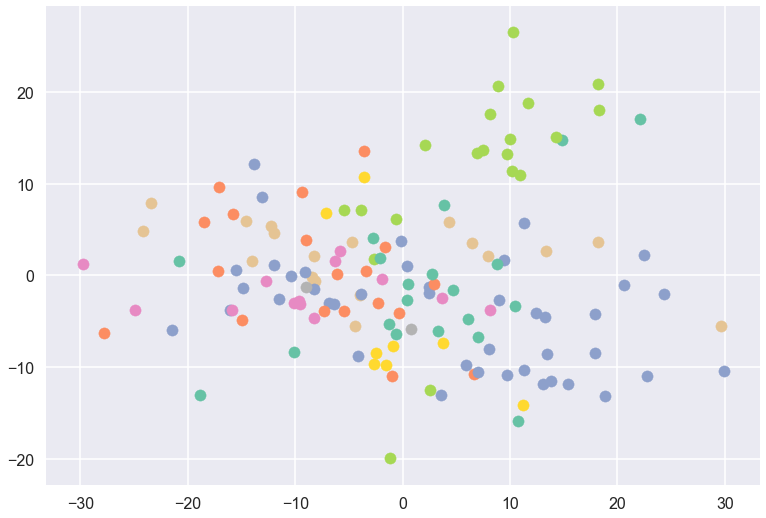

In [211]:
#PCA

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
sns.set_context('poster')
sns.set_palette(sns.color_palette("Set2", 22))
# sns.
last_layer_data = results[-1].data.numpy()
pca_tx = PCA(n_components=15).fit_transform(last_layer_data)
#tsne_tx = TSNE(n_components=2).fit_transform(pca_tx)
for tissue in np.unique(tissues):
    mask = tissues == tissue
    plt.scatter(pca_tx[mask, 0], pca_tx[mask, 1], label=tissue)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("PCA of Different Cell Lines")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [43]:
pca_tx

array([[  3.35713174, -11.31866975],
       [ 21.98670631,  -4.63599279],
       [  6.12154625, -12.66230587],
       [  1.85565211, -18.26681846],
       [  5.57552753, -14.72323718],
       [ -1.29106478,  -6.29364497],
       [-20.03284309,  10.56670956],
       [ 13.26908714,  18.24568581],
       [-13.22756971,  -9.16450544],
       [-10.11575253, -11.97885387],
       [-13.23097574,  15.50898129],
       [-11.99998292,  -4.32379958],
       [-11.53382081, -13.26629366],
       [ 16.31846984,  -0.71189697],
       [ 19.67287668,  12.5917366 ],
       [  7.86389781, -10.26470401],
       [ -9.92000796,  -3.11171267],
       [ 12.8739056 , -12.47425396],
       [  1.43138064,  -1.24707758],
       [-12.71711155,  17.63021712],
       [  7.17640973, -12.95589618],
       [ 21.92950679,   6.16968055],
       [-20.99750806,  -1.71528777],
       [-22.74972479,  11.71246415],
       [  0.39668555,  -3.66945736],
       [  8.20083056,  -7.47478579],
       [ 16.00192794, -10.0763362 ],
 

In [11]:
calculateRMSE(predictions, ytestdat)

1.008651225931414

In [14]:
#print RMSEs and correlations without function

mses = []
cors = []
multitaskrmses = []

preds = predictions.data.numpy()
ytests = ytestdat.values

for i in range(preds.shape[1]):
    mses.append(((preds[:,i] - ytests[:,i])**2).mean())
    multitaskrmses.append(sqrt(mses[i]))
    
    cor = str(sp.stats.spearmanr(ytests[:,i], preds[:,i]))
    cors.append(float(cor[28:37]))
    

print(np.mean(multitaskrmses))
print(np.mean(cors))

1.00865122593
0.328818188752


In [99]:
#LOAD STUFF FOR COMPARISONS
myrmses = np.load('myrmses2.npy')
mycors = np.load('mycors2.npy')

myrmses = myrmses.tolist()
myrmses = list(myrmses.values())

mycors =  mycors.tolist()

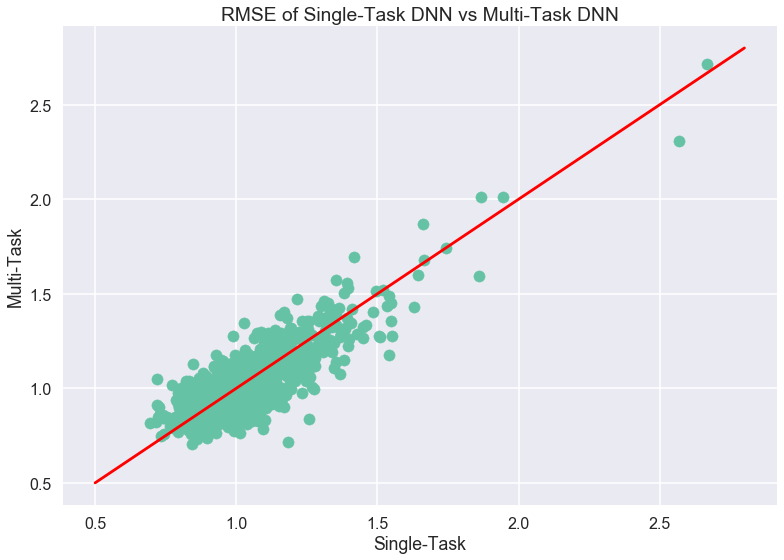

In [188]:
#PLOT RMSES
plt.scatter(myrmses, multitaskrmses2)
sns.set_context('poster')

plt.xlabel('Single-Task')
plt.ylabel('Multi-Task')
plt.title('RMSE of Single-Task DNN vs Multi-Task DNN')
plt.plot([0.5, 2.8], [0.5, 2.8], color = 'red')

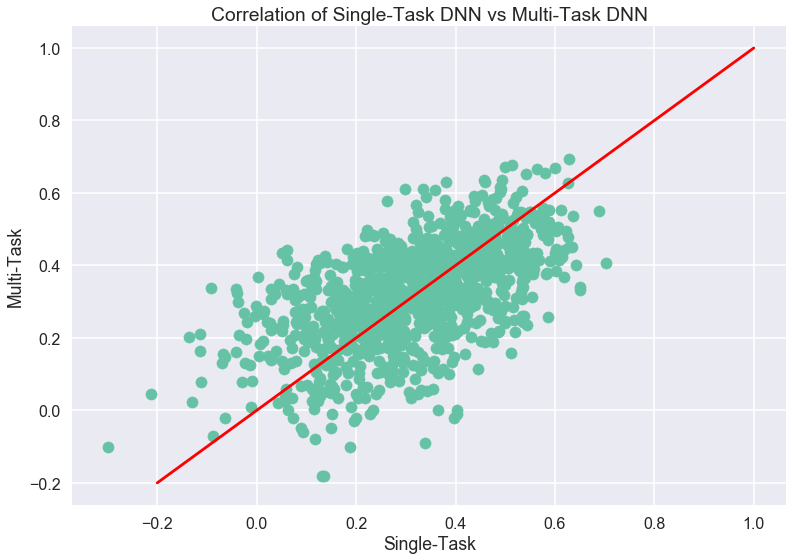

In [189]:
#PLOT CORRELATIONS
plt.scatter(mycors, cors2)
plt.xlabel('Single-Task')
plt.ylabel('Multi-Task')
plt.title('Correlation of Single-Task DNN vs Multi-Task DNN')
plt.plot([-0.2, 1], [-0.2, 1], color = 'red')

In [221]:
vladormses = top_tasks['jklm.rmse'].tolist()

print(np.mean(vladormses))

0.999549503206


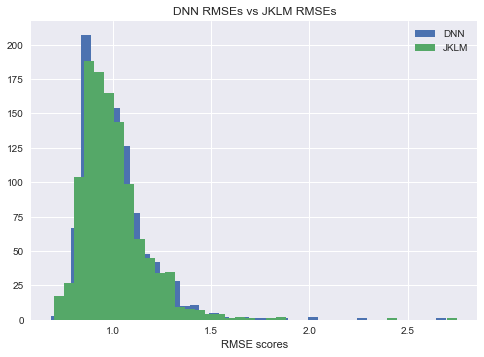

In [224]:
plt.hist(multitaskrmses,40,label = "DNN")
plt.hist(vladormses,40, label = "JKLM")
plt.title("DNN RMSEs vs JKLM RMSEs")
plt.xlabel('RMSE scores')
# plt.ylabel('2 layer DNN')
plt.legend()

In [146]:
#Grid search for network parameters

x = [[[figureoutnetwork(k,i,j) for i in [200,350,450,500]] for j in [0.005,0.01,0.02,0.03]] for k in [3,4,5,6]]

In [120]:
neuronnum = [200,350,450,500]
l2reg = [0.005,0.01,0.02,0.03]

In [97]:
heatmap3layer = pd.DataFrame(x[0], columns=neuronnum, index=l2reg)
# heatmap3layer.insert(0,0.0001,supplementalgrid[0])
heatmap3layer.loc[0.0001] = supplementalgrid[0]
# heatmap3layer.index = heatmap
heatmap4layer= pd.DataFrame(x[1], columns=neuronnum, index=l2reg)
heatmap4layer.loc[0.0001] = supplementalgrid[1]
heatmap5layer= pd.DataFrame(x[2], columns=neuronnum, index=l2reg)
heatmap5layer.loc[0.0001] = supplementalgrid[2]
heatmap6layer= pd.DataFrame(x[3], columns=neuronnum, index=l2reg)
heatmap6layer.loc[0.0001] = supplementalgrid[3]
heatmap6layer = heatmap6layer.sort_index()



NameError: name 'x' is not defined

In [208]:

# h3 = sns.heatmap(heatmap3layer, vmin = 1.005, vmax = 1.079, annot=True, fmt="f")
# h3.set_title("3 Layer Network RMSE Map")
h3

NameError: name 'h3' is not defined

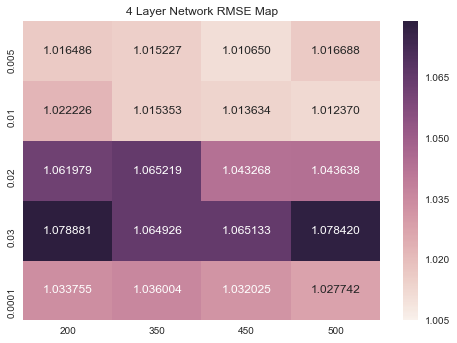

In [183]:
h4 = sns.heatmap(heatmap4layer, vmin = 1.005, vmax = 1.079, annot=True, fmt="f")
h4.set_title("4 Layer Network RMSE Map")

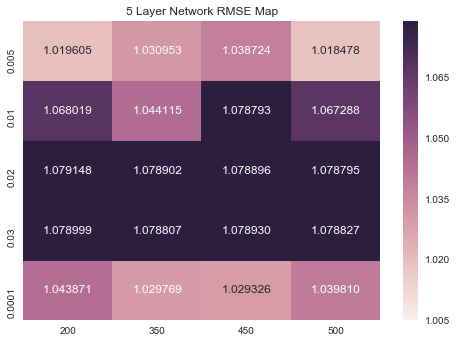

In [184]:
h5 = sns.heatmap(heatmap5layer, vmin = 1.005, vmax = 1.079, annot=True, fmt="f")
h5.set_title("5 Layer Network RMSE Map")

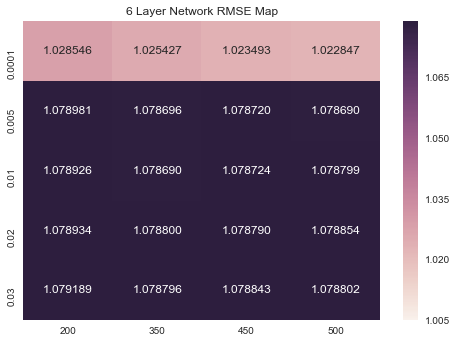

In [186]:
h6 = sns.heatmap(heatmap6layer, vmin = 1.005, vmax = 1.079, annot=True, fmt="f")
h6.set_title("6 Layer Network RMSE Map")

In [21]:
#add to combined stats
combinedstats = pd.read_csv("../combined_stats.tab", sep='\t')
combinedstats['dnn.rmse'] = myrmses

combinedstatsrmses = combinedstats[['jklm.rmse', 'ranger.rmse', 'mkl.d9.rmse', 'rf.d9.rmse', 'glmm.dense.rmse', 'glmm.sparse.rmse', 'dnn.rmse']]
combinedstatsrmses



NameError: name 'myrmses' is not defined

In [19]:
#Best RMSE performance among methods

best_rmse = {'dnn.rmse':0,'glmm.dense.rmse':0, 'mkl.d9.rmse':0, 'rf.d9.rmse':0,'jklm.rmse':0, 'glmm.sparse.rmse':0, 'ranger.rmse':0}

for i in range(1138):
    best_rmse[np.argmin(combinedstatsrmses.iloc[i])] += 1
#     print(np.argmin(combinedstatsrmses.iloc[i]))

best_rmse

NameError: name 'combinedstatsrmses' is not defined

In [22]:
colors = 'rgbkymc'
keys = []

keys = [s.replace(".rmse", "").upper() for s in list(whodidbest.keys())]

plt.bar(range(len(best_rmse)), best_rmse.values(), align='center', color=colors)
plt.xticks(range(len(best_rmse)), keys, rotation='vertical')
plt.title('Number of Essentiality Scores Predicted Best for Each Method')

plt.show()

NameError: name 'whodidbest' is not defined